# Automatically plot Antarctic cross-section/profiles
This notebook contains a simple script to plot cross-sections of Antarctica earth layers and data profiles. Choose your cross-section location as either a straight lines between 2 points, or to follow the path of a shapefile. Choose which earth layers to plot, such as Bedmachine or Bedmap. Also, include dataset to plot profiles of, such as ice velocity, gravity, or magnetics. 

Feel free to reach out with any questions or suggestions.

*Matt Tankersley*  
*Antarctic Research Centre, Victoria University of Wellington, NZ*    
*matthew.tankersley@vuw.ac.nz*  


### Datasets

The following datasets are provided in /sample_data or need to be download from their respective URL's.
* BedMachine bathymetry (Morlighem et al., 2020. https://doi.org/10.1038/s41561-019-0510-8)
    - https://nsidc.org/data/NSIDC-0756/versions/2
* MEaSUREs grounding line and coastline (Rignot et al., 2013. https://doi.org/10.1126/science.1235798)
    - https://nsidc.org/data/nsidc-0709
* MODIS-MOA satellite imagery (Scambos et al., 2007. https://doi.org/10.1016/j.rse.2006.12.020)
    - https://nsidc.org/data/NSIDC-0593
    - get geotiff "moa750_2009_hp1_v02.0.tif"

In [1]:
#import necessary packages 
import pygmt
import pandas as pd
import numpy as np
import geopandas as gpd

### Define cross-section/profile location
2 options:
* input 2 sets of x/y coordinates (in EPSG 3031) marking the beginning and end of the line. 
* set path to a shapefile which defines the line


Note: shapefiles can be made quickly in QGIS. To increase the sampling resolution, use the QGIS tools "Points along geometry" and "Points to path" to increase the number of points on your shapefile

In [2]:
# choose one of the below
METHOD = "points"
# METHOD = "shapefile"

# siple coast
a=(-590000,-1070000)
b=(-100000,-545000)

# discovery deep
# a=(307320,-1140665)
# b=(274470,-1156657)

# West to East Antarcitca
# a=(-1689974,-874525)
# b=(2174939,1721844)

# N-S line along center of Ross Ice Shelf, as defined by the Mid-Shelf High basement feature (Tankersley et al. 2022, GRL)
# gdf=gpd.read_file('C:/Users\matthewt\Documents\Python_Scripts\shapefiles\EANT_WANT_divide_10k.shp')

# Line from ice shelf calving front to the grounding zone through Roosevelt Island
gdf=gpd.read_file('sample_data\Roosevelt_Island_10k.shp')

### Choose input datasets and colors

In [3]:
# earth-layer data to plot in cross-section
earth_profilelist=(
    'sample_data\BedMachine_surface_wgs_10k.nc',
    'sample_data\BedMachine_icebase_wgs_10k.nc',
    'sample_data\BedMachine_bed_wgs_10k.nc',
    # 'C:/Users/matthewt/Documents/Python_Scripts/GRL_2021_Figures/tmp/BedMachine_surface_wgs_5k.nc',
    # 'C:/Users/matthewt/Documents/Python_Scripts/GRL_2021_Figures/tmp/BedMachine_icebase_wgs_5k.nc',
    # 'C:/Users/matthewt/Documents/Python_Scripts/GRL_2021_Figures/tmp/BedMachine_bed_wgs_5k.nc',
    # 'C:/Users/matthewt/Documents/Python_Scripts/GRL_2021_Figures/rosetta_lindeque_basement_g80kfilt.nc', 
    )
x_section_colorlist=(
    'lightskyblue',
    'darkblue',
    'lightbrown',
    # 'chocolate',
    # 'darkbrown',
    )

# data to plot as a seperate profile
data_profilelist=(
    # 'sample_data\BedMachine_bed_wgs_10k.nc',
    # 'C:/Users/matthewt/Documents/Python_Scripts/GRL_2021_Figures/RIS_Grav_5k.nc',
    # 'C:/Users/matthewt/Documents/Python_Scripts/GRL_2021_Figures/RIS_Mag_5k.nc', 
    # 'C:/Users/matthewt/Documents/Python_Scripts/PyGMT/Venturelli2020/antarctic_ice_vel_phase_map_v01-vmag.nc',
    )
profile_colorlist=(
    'blue',
    'red',
    'black',
    )

# background grid and colorscale for map    
plot_grid='C:/Users\matthewt\Documents\Python_Scripts\RIS_basement_sediment\Data\Download/moa750_2009_hp1_v1.1.tif'
plot_cmap='gray'

# buffer as percentage added to profile location on map; i.e. .4 adds 40% of profile extent on map.
buffer_perc=.2

### Code for sampling the data

In [4]:
def create_profile(a, b): # function to create points every 1000m between points 'a' and 'b'
    df = pd.DataFrame(data=np.linspace(start=a, stop=b, num=1000), columns=["x", "y"])
    return df

def sample_line(points, data): # function to sample data at every point along line
    points[data] = (pygmt.grdtrack(points=points, grid=data, newcolname=str(data)))[data]
    return points

if METHOD == 'points':
    points = create_profile(a, b)
elif METHOD == 'shapefile':
    shape=pd.DataFrame()
    shape['coords']=gdf.geometry[0].coords[:]
    points=shape.coords.apply(pd.Series, index=['x','y'])
else:
    print("please choose a valid method, either 'points', or 'shapefile'")

# distance along line 
points['Distance'] = np.sqrt( (points.x-points.x[0])**2 + (points.y-points.y[0])**2 )
# points=points[points.Distance<800000] # use this to shorten line if necessary

# sample cross-section layers from grids
for i in earth_profilelist:
    earth_profiles=sample_line(points, i)
    
# use this to fill NaN's in layers with the values from layer above
for y in list(range(len(earth_profilelist)))[1:]:  #fill NaN's in lower layer with upper layer
    earth_profiles[earth_profilelist[y]] = np.where(earth_profiles[earth_profilelist[y]].isnull(), 
                                                    earth_profiles[earth_profilelist[y-1]], 
                                                    earth_profiles[earth_profilelist[y]]) 
# reset points dataframe (remove sampled columns)
points=points[['x','y','Distance']].copy()

# if grids in Data profile list, sample them
try:    
    
    for i in data_profilelist:
        data_profiles=sample_line(points, i)
except:
    print('no data profiles to plot')

### Plot the results

C:\Users\matthewt\AppData\Local\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\matthewt\AppData\Local\miniforge3\envs\pygmt06\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
gmtset [WARNING]: Representation of font type not recognized. Using default.


error plotting data profiles


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


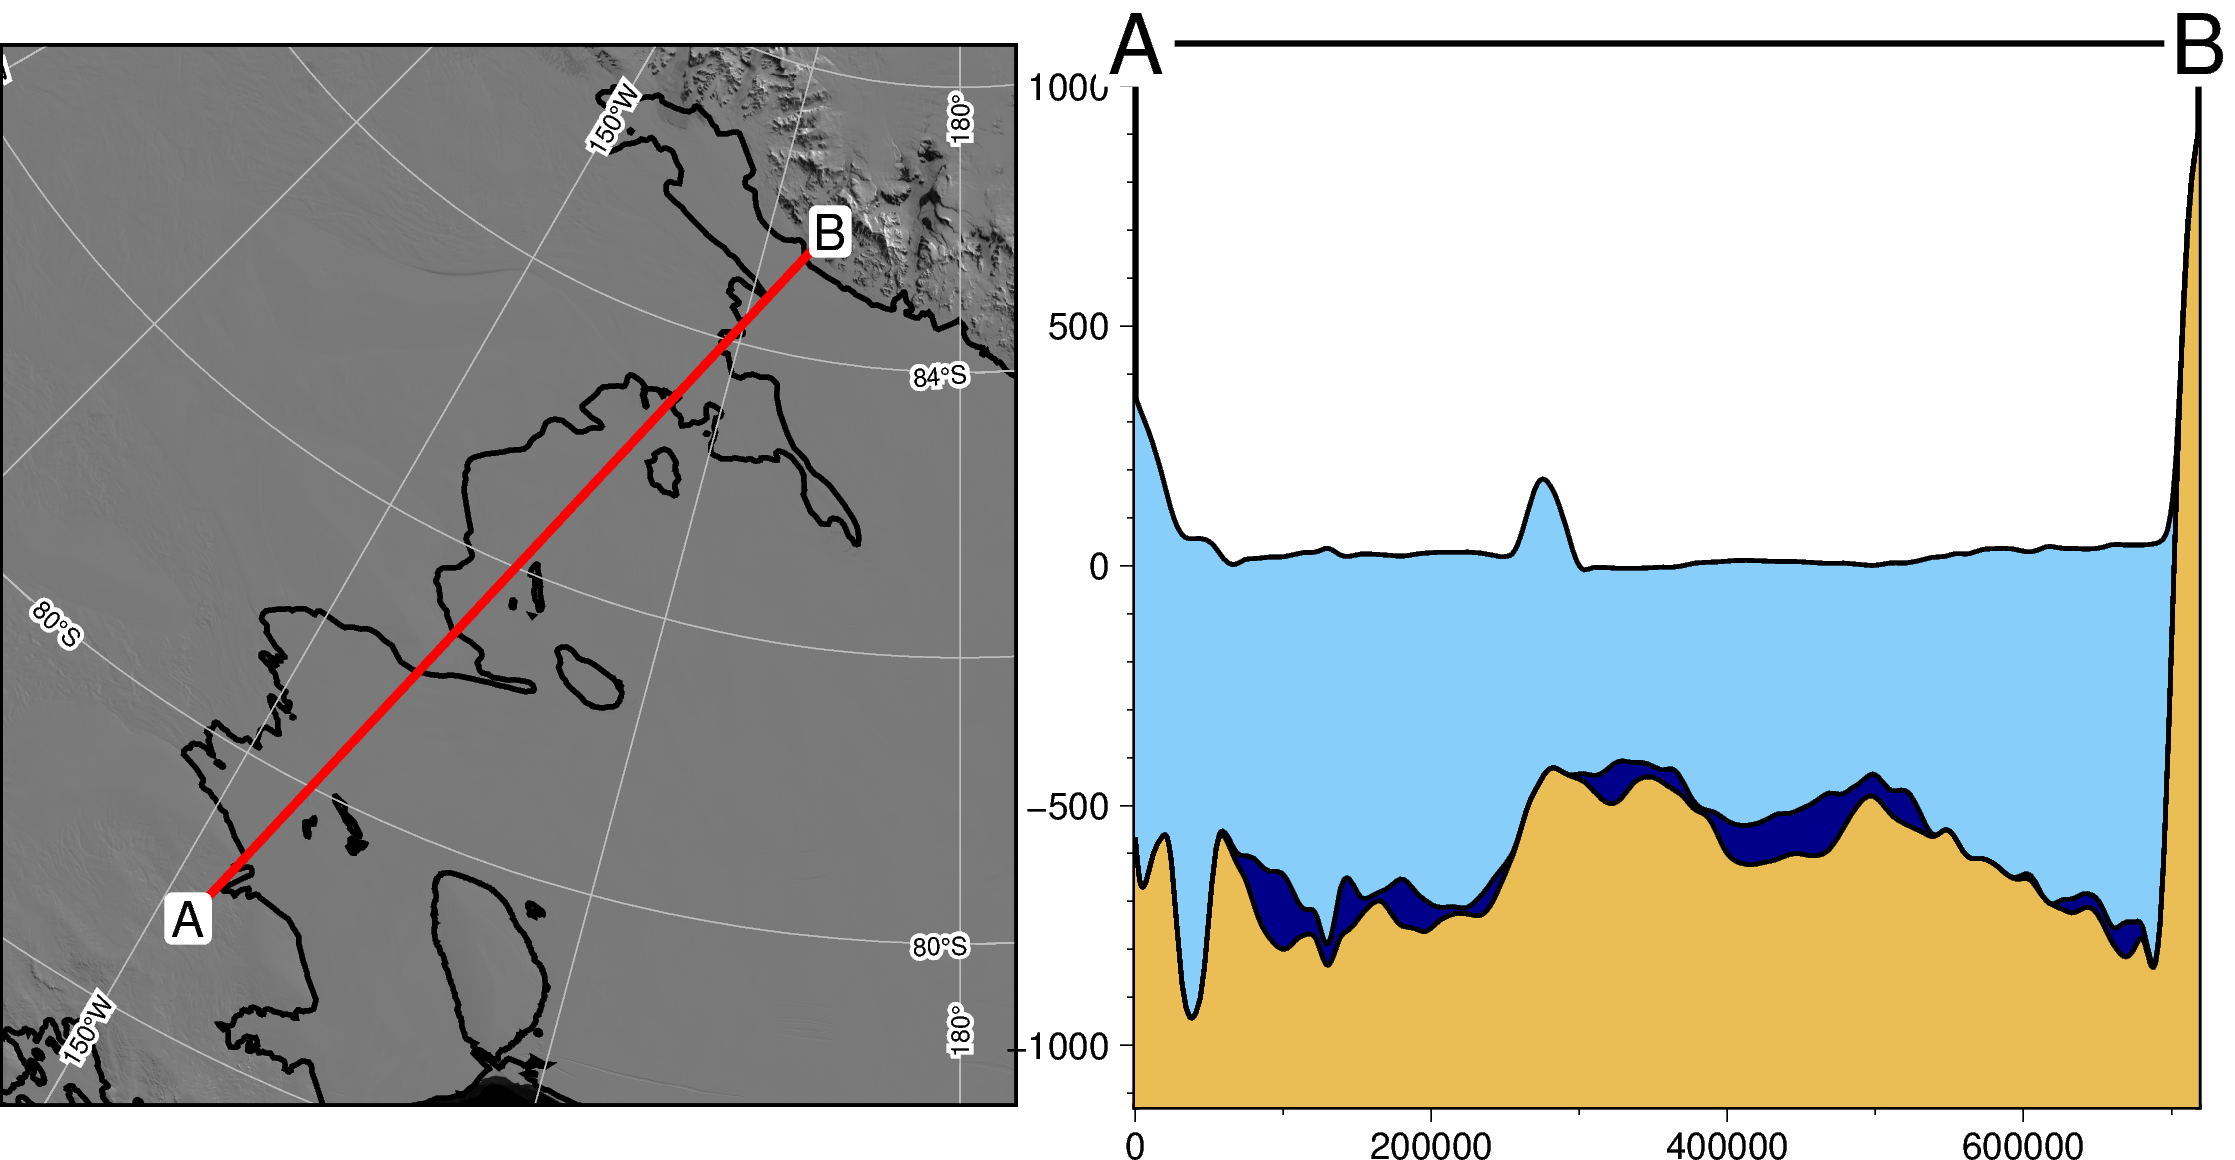

In [5]:
figheight=90 # in mm

#Automatic data extent + buffer as % of line length
buffer=earth_profiles.Distance.max()*buffer_perc
xl= earth_profiles.x.min()-buffer
yl= earth_profiles.y.min()-buffer
xh= earth_profiles.x.max()+buffer
yh= earth_profiles.y.max()+buffer

figwidth=figheight*(xh-xl)/(yh-yl) 
fig_ratio = (yh - yl) / (figheight/1000)
fig_reg = str(xl) + '/' + str(xh) + '/' + str(yl) + '/' + str(yh) #W/E/S/N
fig_proj = "x1:" + str(fig_ratio)
fig_proj_ll = "s0/-90/-71/1:" + str(fig_ratio)

fig = pygmt.Figure()

"""

PLOT MAP 

"""

with pygmt.config(MAP_FRAME_TYPE = 'inside'):
    fig.coast(region=fig_reg, projection=fig_proj_ll, land = 'grey', water = 'grey', 
              frame = ["nwse", "xf100000", "yf100000", "g0"],verbose='e')

fig.grdimage(projection = fig_proj, 
             grid=plot_grid,
             cmap=plot_cmap)

# plot groundingline and coastlines
fig.plot(data=gpd.read_file('sample_data/GroundingLine_Antarctica_v02.shp'), 
         pen = '1.2p,black', verbose='e')
fig.plot(data=gpd.read_file('sample_data/Coastline_Antarctica_v02.shp'), 
         pen='1.2p,black', verbose='e')

# Plot graticules overtop, at 4d latitude and 30d longitude
with pygmt.config(MAP_ANNOT_OFFSET_PRIMARY = '-2p', MAP_FRAME_TYPE = 'inside',
                  MAP_ANNOT_OBLIQUE = 0, FONT_ANNOT_PRIMARY = '6p,black,-=2p,white', 
                  MAP_GRID_PEN_PRIMARY = 'grey', MAP_TICK_LENGTH_PRIMARY = '-10p',
                  MAP_TICK_PEN_PRIMARY = 'thinnest,grey', FORMAT_GEO_MAP = 'dddF',
                  MAP_POLAR_CAP = '90/90', ):
    fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30g15", "ya4g2"], verbose='e')
    with pygmt.config(FONT_ANNOT_PRIMARY = '6p,black'):
        fig.basemap(projection = fig_proj_ll, region = fig_reg,
                frame = ["NSWE", "xa30", "ya4"], verbose='e')

# plot profile location, and endpoints on map   
fig.plot(projection=fig_proj, region=fig_reg, x=earth_profiles.x, y=earth_profiles.y, pen='2p,red')
fig.text(x = earth_profiles.loc[earth_profiles.Distance.idxmin()].x,
        y = earth_profiles.loc[earth_profiles.Distance.idxmin()].y, 
        text = "A", fill = 'white', font = '12p,Helvetica,black', justify="CM", clearance = '+tO')
fig.text(x = earth_profiles.loc[earth_profiles.Distance.idxmax()].x,
        y = earth_profiles.loc[earth_profiles.Distance.idxmax()].y, 
        text = "B", fill = 'white', font = '12p,Helvetica,black', justify='CM', clearance = '+tO')

# shift figure to the right to make space for x-section and profiles
fig.shift_origin(xshift=(figwidth/10)+1)

"""

PLOT CROSS-SECTION AND PROFILES

"""
# add space above and below top and bottom x-section layers
y_buffer=(earth_profiles[earth_profilelist[0]].max()-earth_profiles[earth_profilelist[-1]].min())*.1
# set region for x-section
region_layers=[earth_profiles.Distance.min(), earth_profiles.Distance.max(),
        earth_profiles[earth_profilelist[-1]].min()-y_buffer,
        earth_profiles[earth_profilelist[0]].max()+y_buffer]

# if data for profiles is set, set region and plot them, if not, make region for x-section fill space
if data_profilelist:
    try:
        for i in list(range(len(data_profilelist))):
            color=list(np.random.random(size=3) * 256) 
            region_data=[data_profiles.Distance.min(), data_profiles.Distance.max(),
                        data_profiles[data_profilelist[i]].min(),
                        data_profiles[data_profilelist[i]].max()]
            # fig.basemap(region=region_data, projection="X9c/2.5c", frame=False)
            fig.plot(region=region_data, projection="X9c/2.5c", frame=['nS','ag'], 
                     x=data_profiles.Distance, y=data_profiles[data_profilelist[i]], 
                     pen='2p,'+str(profile_colorlist[i]))
        fig.shift_origin(yshift="h+.5c")
        fig.basemap(region=region_layers, projection="X9c/6c", frame=True)
    except:
        pass
else:    
    print('error plotting data profiles')
    fig.basemap(region=region_layers, projection="X9c/9c", frame=True)
    

# plot x-section colored layers
for i in list(range(len(earth_profilelist))):
    fig.plot(x=earth_profiles.Distance, y=earth_profiles[earth_profilelist[i]],
        close='+yb', color=x_section_colorlist[i])
# plot lines between layers
for i in earth_profilelist:
    fig.plot(x=earth_profiles.Distance, y=earth_profiles[i], pen='1p,black')
# plot 'A', 'B' locations
fig.text(x=region_layers[0], y=region_layers[3], text='A', font='20p,Helvetica,black', 
         justify='CM', fill='white', no_clip=True)
fig.text(x=region_layers[1], y=region_layers[3], text='B', font='20p,Helvetica,black', 
         justify='CM', fill='white', no_clip=True)

fig.show()